Demand Forecast For SanFrancisco
--

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from xgboost import plot_importance
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
import math
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Solve problem with xgb error

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
city = 'SanFrancisco'

In [4]:
calendar = pd.read_csv('../HolidaysForForecastAdjustments.csv')
calendar.dropna(inplace=True, axis=1, how='all')
calendar.dropna(inplace=True, axis=0, how='all')
calendar_BAK = calendar.copy()

In [5]:
calendar_BAK

,Holiday,2016,2017,2018,2019,2020
0,NewYearsDay,1/1/16,1/1/17,1/1/18,1/1/19,1/1/20
1,MartinLurtherKingDay,1/18/16,1/16/17,1/15/18,1/21/19,1/20/20
2,SuperBowl,2/7/16,2/5/17,2/4/18,2/3/19,2/2/20
3,ValentinesDay,2/14/16,2/14/17,2/14/18,2/14/19,2/14/20
4,PresidentsDay,2/15/16,2/20/17,2/19/18,2/18/19,2/17/20
5,Easter,3/27/16,4/16/20,4/1/18,4/21/19,4/12/20
6,MothersDay,5/8/16,5/14/17,5/13/18,5/12/19,5/10/20
7,MemorialDay,5/30/16,5/29/17,5/28/18,5/27/19,5/25/20
8,IndependenceDay,7/4/16,7/4/17,7/4/18,7/4/19,7/4/20
9,LaborDay,9/5/16,9/4/17,9/3/18,9/2/19,9/7/20


In [6]:
df_2016 = calendar_BAK[['2016', 'Holiday']].copy().rename(columns={'2016':'date'})
df_2017 = calendar_BAK[['2017', 'Holiday']].copy().rename(columns={'2017':'date'})
df_2018 = calendar_BAK[['2018', 'Holiday']].copy().rename(columns={'2018':'date'})
df_2019 = calendar_BAK[['2019', 'Holiday']].copy().rename(columns={'2019':'date'})
df_2020 = calendar_BAK[['2020', 'Holiday']].copy().rename(columns={'2020':'date'})
calendar = pd.concat([df_2016, df_2017, df_2018, df_2019, df_2020])
calendar['date'] = pd.to_datetime(calendar['date'], infer_datetime_format=True)
calendar['date'] = calendar['date'].map(lambda x: x.date())

In [7]:
demand = pd.read_csv(city + '_Demands.csv').rename(columns={'DEMAND':'demand'})
forecast = pd.read_csv(city + '_Forecasts.csv').rename(columns={'DEMAND':'forecast'})
df = demand.merge(forecast, on='DATE', how='left').rename(columns={'DATE':'date'})
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
first_date = datetime(2016,1,1,0,0).date()
df['first_date'] = pd.DataFrame([first_date for i in range(len(df))])
df['date'] = df['date'].map(lambda x: x.date())
df['days'] = df['date'] - df['first_date']
df['days'] = df['days'].map(lambda x: x.days)
df_BAK = df.copy()
df = df_BAK[df_BAK['date'] >= first_date].copy()\
    .reset_index().drop(columns=['index'], axis=1)
df = df.merge(calendar, on='date', how='left')

In [8]:
df.head(3)

,date,demand,forecast,first_date,days,Holiday
0,2016-01-01,712.358926,NaN,2016-01-01,0,NewYearsDay
1,2016-01-02,1735.837215,NaN,2016-01-01,1,NaN
2,2016-01-03,2848.295065,NaN,2016-01-01,2,NaN


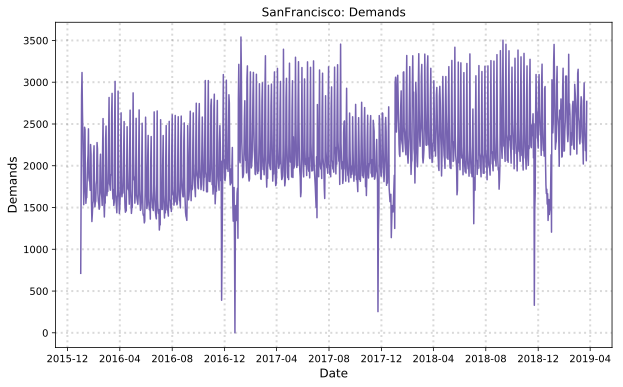

In [9]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)
ax1.plot(df['date'], df['demand'], color='#7663b0')
ax1.set_xlabel('Date',fontsize=12)
ax1.set_ylabel('Demands',fontsize=12)
ax1.set_title(city + ': ' + 'Demands')
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
plt.savefig(city + '_demands.png')
plt.show()

In [10]:
df.head(3)

,date,demand,forecast,first_date,days,Holiday
0,2016-01-01,712.358926,NaN,2016-01-01,0,NewYearsDay
1,2016-01-02,1735.837215,NaN,2016-01-01,1,NaN
2,2016-01-03,2848.295065,NaN,2016-01-01,2,NaN


In [11]:
df.notnull().sum()

date          1177
demand        1177
forecast      1101
first_date    1177
days          1177
Holiday         47
dtype: int64

In [12]:
from sklearn import linear_model
X = np.array(df['days']).reshape(-1, 1)
y = np.array(df['demand'])

lr = linear_model.LinearRegression()
lr.fit(X, y)
predict = lr.predict(X)
df['lineardemand'] = pd.DataFrame(predict)

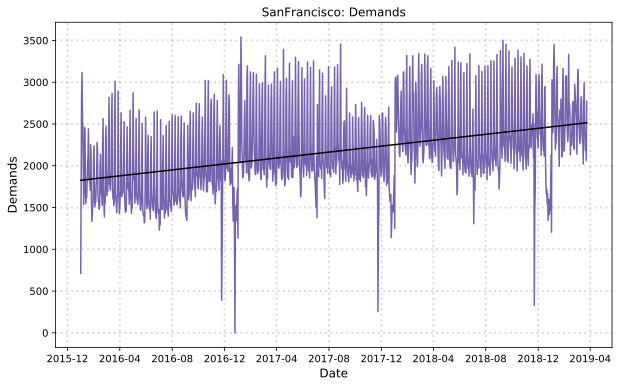

In [13]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)
ax1.plot(df['date'], df['demand'], color='#7663b0')
ax1.plot(df['date'], df['lineardemand'], color='black')
ax1.set_xlabel('Date',fontsize=12)
ax1.set_ylabel('Demands',fontsize=12)
ax1.set_title(city + ': ' + 'Demands')
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
plt.show()

In [14]:
df['demand_m'] = df['demand'] - df['lineardemand']
df['forecast_m'] = df['forecast'] - df['lineardemand']

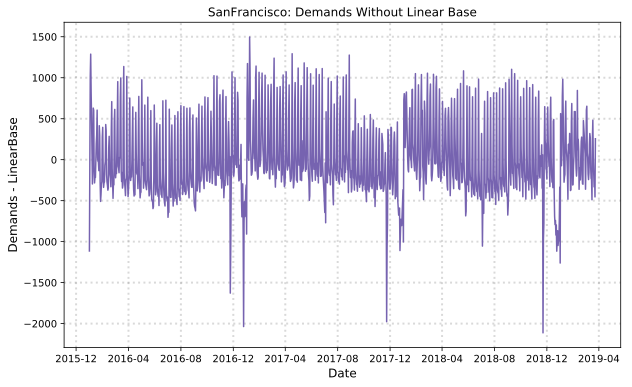

In [15]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)
ax1.plot(df['date'], df['demand_m'], color='#7663b0')
ax1.set_xlabel('Date',fontsize=12)
ax1.set_ylabel('Demands - LinearBase',fontsize=12)
ax1.set_title(city + ': ' + 'Demands Without Linear Base')
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
plt.show()

In [16]:
df['error'] = abs(df['forecast'] - df['demand']) / df['demand']

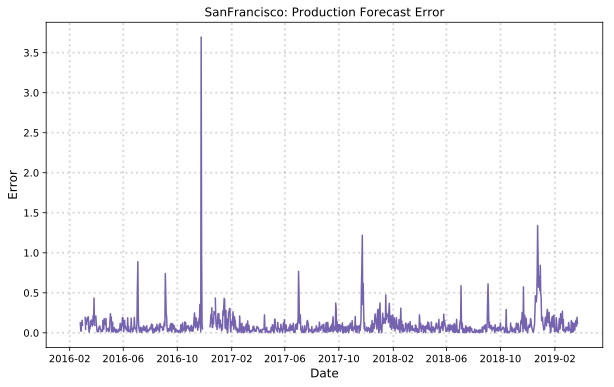

In [17]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)
ax1.plot(df['date'], df['error'], color='#7663b0')
ax1.set_xlabel('Date',fontsize=12)
ax1.set_ylabel('Error',fontsize=12)
ax1.set_title(city + ': ' + 'Production Forecast Error')
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
plt.savefig(city + '_forecast_errors.png')
plt.show()

In [18]:
print('Predict mean error: %8.3f'%(df['error'].mean()))
print('Predict median error: %8.3f'%(df['error'].median()))

Predict mean error:    0.095
Predict median error:    0.058


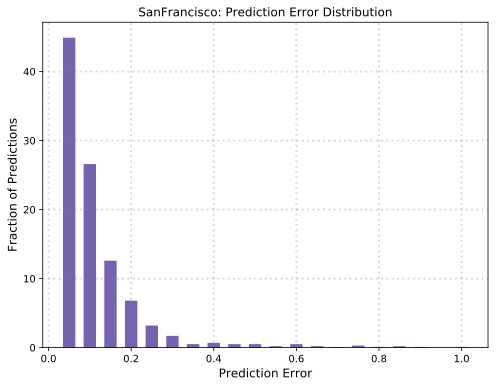

In [19]:
tot = df['error'].notnull().sum()
bins2=[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4,\
      0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85,\
      0.9, 0.95, 1.0]
y, divisions = np.histogram(df['error'], bins=bins2)
y = [round(i / float(tot), 3) * 100 for i in y]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(bins2[1:], y, align='center', color='#7663b0', width=0.03)
ax1.set_xlabel('Prediction Error',fontsize=12)
ax1.set_ylabel('Fraction of Predictions',fontsize=12)
ax1.set_title(city + ': ' +\
              'Prediction Error Distribution')
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
plt.savefig(city + '_forecast_errors_hist.png')
plt.show()

In [20]:
df['weekday'] = df['date'].map(lambda x: x.weekday())
df['month'] = df['date'].map(lambda x: x.month)
df['year'] = df['date'].map(lambda x: x.year)

In [21]:
df[df['error'] > 1]

,date,demand,forecast,first_date,days,Holiday,lineardemand,demand_m,forecast_m,error,weekday,month,year
328,2016-11-24,390.208216,1831.99,2016-01-01,328,ThanksgivingDay,2017.847809,-1627.639593,-185.857809,3.694904,3,11,2016
692,2017-11-23,253.682863,562.85,2016-01-01,692,ThanksgivingDay,2230.353563,-1976.670700,-1667.503563,1.218715,3,11,2017
1087,2018-12-24,1345.436927,3149.28,2016-01-01,1088,NaN,2461.541140,-1116.104213,687.738860,1.340712,0,12,2018


## Feature Engineerings

In [22]:
# Holidays
holidays = df[df['Holiday'].notnull()]['Holiday'].unique().tolist()
for i in holidays:
    df[i] = df['Holiday'].map(lambda x: 1 if x == i else 0)

# To Thanksgiving    
txgv_2016 = datetime(2016,11,24,0,0).date()
txgv_2017 = datetime(2017,11,23,0,0).date()
txgv_2018 = datetime(2018,11,22,0,0).date()
txgv_2019 = datetime(2019,11,28,0,0).date()
df['to_thanksgiving'] = df['date'].map(lambda x: (x - txgv_2016).days if x.year == 2016 else\
                                      (x - txgv_2017).days if x.year == 2017 else
                                      (x - txgv_2018).days if x.year == 2018 else 
                                      (x - txgv_2019).days if x.year == 2019 else
                                       0)

In [23]:
features = ['weekday', 'month', 'to_thanksgiving', 'year'] + holidays

## Hyperparameter Tuning

In [24]:
# Utility functions

def Prior_Month(fscl_mn_id):
    year = int(fscl_mn_id / 100)
    mn = fscl_mn_id % 100
    
    if mn == 1:
        return (year - 1) * 100 + 11
    elif mn == 2:
        return (year - 1) * 100 + 12
    else:
        return year * 100 + mn - 2
    
def One_Month(fscl_mn_id):
    year = int(fscl_mn_id / 100)
    mn = fscl_mn_id % 100
    
    if mn == 1:
        return (year - 1) * 100 + 12
    else:
        return year * 100 + mn - 1

In [25]:
# Reset index, otherwise there is problem with my own CViterator
df['fscl_mn_id'] = df['date'].map(lambda x: x.year * 100 + x.month)

myCViterator = []
for time_filter in [201807, 201808, 201809, 201810, 201811, 201812]:
    prior_mn = One_Month(time_filter)
    trainIndices = df[df.fscl_mn_id <= prior_mn].index.values.astype(int)
    testIndices =  df[df.fscl_mn_id == time_filter].index.values.astype(int)
    myCViterator.append( (trainIndices, testIndices) )

In [26]:
flag_model = 'xgb' # 'xgb' or 'rf'
flag_search = 'random' # 'grid' or 'random'

time_filter = 201901

# Get train, test and predict DataFrame
train_data = df[features].copy()
predict_data = df[df.fscl_mn_id >= time_filter][features].copy()

train_label = df['demand_m'].copy()
predict_label = df[df.fscl_mn_id >= time_filter]\
    [['date', 'demand', 'demand_m', 'lineardemand', 'forecast', 'fscl_mn_id', 'error']].copy()

# Define Model Parameters    
xgb = XGBRegressor(n_jobs=-1, silent=1, subsample=0.9, eval_metric='rmse')    
rf = RandomForestRegressor(n_jobs=-1)

if flag_model == 'xgb': 
    model = xgb
    params_grid = {
        "max_depth" : [3, 4, 5, 6, 7],
        "n_estimators": [20, 40, 60, 80, 100, 120, 140],
        "min_child_weight": [1, 3, 5],
        "gamma": [i/10.0 for i in range(3,6)]
         }
    params_random = {
        "max_depth" : [2, 3, 4, 5, 6, 7, 8, 9],
        "n_estimators": [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140],
        "min_child_weight": [1, 2, 3, 4, 5, 6],
        "gamma": [i/10.0 for i in range(3,6)]
         }
else:
    model = rf
    params_grid = {
    "n_estimators" : [40, 60, 80, 100, 120, 140, 160, 180],
    "max_depth" : [3, 4, 5, 6, 7, 8],
    "min_samples_leaf" : [1, 2, 4],
    "criterion":['mse']  # 'mae'
     }
    params_random = {
    "n_estimators" : [40, 50, 60, 70, 80, 90, 100, 100, 120, 130, 140, 150, 160, 170, 180],
    "max_depth" : [3, 4, 5, 6, 7, 8],
    "min_samples_leaf" : [1, 2, 3, 4, 5],
    "criterion":['mse']  # 'mae'
     }
    
if flag_search == 'grid':
    grid = GridSearchCV(estimator=model, param_grid=params_grid, cv=myCViterator)
else:
    grid = RandomizedSearchCV(estimator=model, param_distributions=params_random, cv=myCViterator)

grid.fit(train_data, train_label)
print(grid.best_params_)

/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anacon

/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anacon

{'n_estimators': 120, 'min_child_weight': 1, 'max_depth': 6, 'gamma': 0.5}


/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a futu

In [27]:
# Get prediction for each of the month
ypred = grid.best_estimator_.predict(predict_data)
df_pred = predict_label.copy()
df_pred = df_pred.assign(pred=list(ypred))
df_pred['pred'] = df_pred['pred'] + df_pred['lineardemand']
    
# After prediction for all the month, get all APE and MAPE.
df_pred['ape'] = (df_pred['pred'] - df_pred['demand']) / df_pred['demand']
df_pred['abs_ape'] = df_pred['ape'].map(lambda x: abs(x))
df_pred['abs_err'] = df_pred['error'].map(lambda x: abs(x))


df_mape = df_pred[['fscl_mn_id', 'abs_ape', 'abs_err']].groupby('fscl_mn_id')\
    .agg({'abs_ape':np.mean, 'abs_err':np.mean}).reset_index()

print(df_mape)

   fscl_mn_id   abs_ape   abs_err
0      201901  0.025916  0.145612
1      201902  0.036571  0.082434
2      201903  0.025208  0.078786


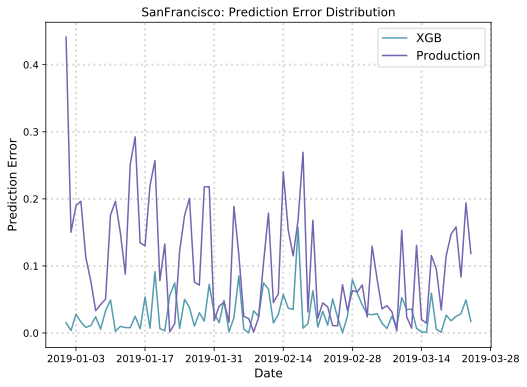

In [28]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.plot(df_pred['date'], df_pred['abs_ape'], color='#539caf', label='XGB')
ax1.plot(df_pred['date'], df_pred['abs_err'], color='#7663b0', label='Production')
ax1.set_xlabel('Date',fontsize=12)
ax1.set_ylabel('Prediction Error',fontsize=12)
ax1.set_title(city + ': ' + 'Prediction Error Distribution')
ax1.legend(loc='upper right', fontsize=12)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
plt.savefig(city + '_forecast_comparison.png')
plt.show()

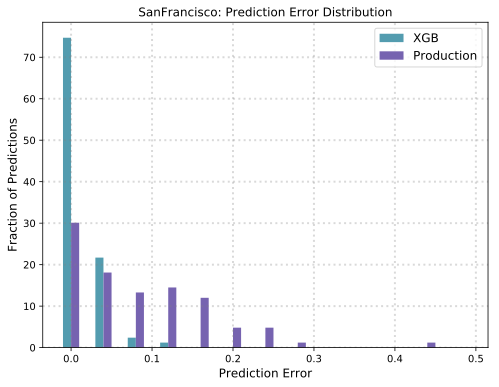

In [29]:
tot = df_pred['abs_err'].notnull().sum()
bins2=[0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32,\
      0.36, 0.4, 0.44, 0.48, 0.52]
x1 = [i - 0.005 for i in bins2[:-1]]
x2 = [i + 0.005 for i in bins2[:-1]]
y1, divisions = np.histogram(df_pred['abs_ape'], bins=bins2)
y1 = [round(i / float(tot), 3) * 100 for i in y1]

y2, divisions = np.histogram(df_pred['abs_err'], bins=bins2)
y2 = [round(i / float(tot), 3) * 100 for i in y2]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#539caf', width=0.01, label='XGB')
ax1.bar(x2, y2, align='center', color='#7663b0', width=0.01, label='Production')
ax1.set_xlabel('Prediction Error',fontsize=12)
ax1.set_ylabel('Fraction of Predictions',fontsize=12)
ax1.set_title(city + ': ' + 'Prediction Error Distribution')
ax1.legend(loc='upper right', fontsize=12)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
plt.savefig(city + '_forecast_comparison_hist.png')
plt.show()